In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 # Cardiovascular Diseases - Heart Failure Prediction
    
    Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives 
    each year, which accounts for 31% of all deaths worlwide. Heart failure is a common event caused by CVDs and this
    dataset contains 12 features that can be used to predict mortality by heart failure.

    Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy
    diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

    People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk 
    factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and 
    management wherein a machine learning model can be of great help.
    
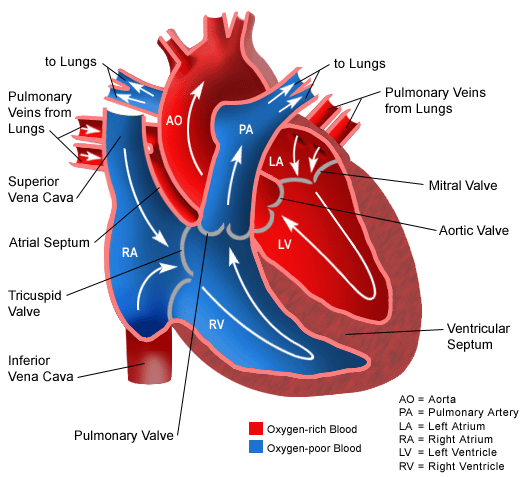
    
 ## Dataset Link 
 
 https://www.kaggle.com/andrewmvd/heart-failure-clinical-data
 
 ## Dataset Description
 
 Feature | Explanation | Measurement	| Range
------------- | ------------- |------------- | -------------
Age	|Age of the patient	|Years |	[40,..., 95]
Anaemia	|Decrease of red <br> blood cells or hemoglobin |	Boolean|	0, 1
High blood pressure |	If a patient has hypertension |	Boolean	 |0, 1
Creatinine phosphokinase<br>(CPK) |	Level of the CPK enzyme <br>in the blood |	mcg/L|	[23,..., 7861]
Diabetes|	If the patient has diabetes |	Boolean	| 0, 1
Ejection fraction|	Percentage of blood leaving<br>the heart at each contraction|Percentage	|	[14,..., 80]
Sex	| Woman or man |	Binary|	0, 1
Platelets|	Platelets in the blood|	kiloplatelets/mL|	[25.01,..., 850.00]
Serum creatinine|	Level of creatinine in the blood|	mg/dL|	[0.50,..., 9.40]
Serum sodium|	Level of sodium in the blood|	mEq/L|	[114,..., 148]
Smoking|	If the patient smokes|	Boolean	|0, 1
Time|	Follow-up period|	Days|	[4,...,285]
DEATH EVENT<br>(TARGET)|	If the patient died during the follow-up period|	Boolean|	0, 1

**NOTE: mcg/L: micrograms per liter. mL: microliter. mEq/L: milliequivalents per litre**
 
 ### References
 
    Machine learning can predict survival of patients with heart failure from serum creatinine and 
    ejection fraction alone. (03 February 2020)
   https://doi.org/10.1186/s12911-020-1023-5

### Required Libraries and Utilities

In [ ]:
# Import the required libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score, matthews_corrcoef
from sklearn.metrics import precision_score, auc, roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from scipy.stats import randint 

from imblearn.over_sampling import SMOTE
from collections import Counter

from xgboost import XGBClassifier

from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols
import plotly.graph_objs as gobj

init_notebook_mode(connected=True)
import plotly.figure_factory as ff

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier

# To display all the columns
pd.options.display.max_columns = None

# To display all the rows
pd.options.display.max_rows = None

# To map Empty Strings or numpy.inf as Na Values
pd.options.mode.use_inf_as_na = True

pd.options.display.expand_frame_repr =  False

%matplotlib inline

# Set Style
sns.set(style = "whitegrid")

### Utility Functions

In [ ]:
# Custom Function to add data labels in the graph

def add_data_labels(ax, spacing = 5):

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}%".format(y_value)

        # Create annotation
        plt.annotate(
            label,                        # Use `label` as label
            (x_value, y_value),           # Place label at end of the bar
            xytext = (0, space),          # Vertically shift label by `space`
            textcoords = "offset points", # Interpret `xytext` as offset in points
            ha = 'center',                # Horizontally center label
            va = va)                      # Vertically align label differently for positive and negative values.

### Import Data

In [ ]:
heart_faliure_data = pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv', 
                                 low_memory = False, skipinitialspace = True, float_precision = 2)

heart_faliure_data.head()

In [ ]:
heart_faliure_data.shape

In [ ]:
# Check the total missing values in each column.
print("Total NULL Values in each columns")
print("*********************************")
print(heart_faliure_data.isnull().sum())

***This looks to be a clean dataset without any missing values...***

## Exploratory Data Analysis

Lets look at the features available to us.

### 1. Univariate Analysis of Categorical variables

#### 'anaemia', 
#### 'high_blood_pressure', 
#### 'diabetes', 
#### 'sex', 
#### 'smoking'

In [ ]:
# Univariate Plot Analysis of Ordered categorical variables vs Percentage Rate
category_list = ['anaemia', 'high_blood_pressure', 'diabetes', 'sex', 'smoking']
counter = 1

plt.figure(figsize = (15, 12))

for col_list in category_list:
        
    series = round(((heart_faliure_data[col_list].value_counts(dropna = False))/
                    (len(heart_faliure_data[col_list])) * 100), 2)

    plt.subplot(2, 3, counter)
    ax = sns.barplot(x = series.index, y = series.values, order = series.sort_index().index)
    plt.xlabel(col_list, labelpad = 15)
    plt.ylabel('Percentage Rate', labelpad = 10)

    # Call Custom Function
    add_data_labels(ax)

    counter += 1

del category_list, counter, ax

plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.5)
plt.show()

#### <font color = brown>Data Insight 1:</font>

**`1. ~57% of the population under study have aneamic symptoms while ~43% are non-aneamic.`**

**`2. ~65% of the population have hypertension or high bloob pressure while ~35% have normal blood pressure.`**

**`3. ~58% of the population are diabetic while ~42% are non-diabetic.`**

**`4. ~65% of the population are male while ~35% are female.`**

**`5. ~68% of the population have smoking habits while ~32% are non-smokers.`**

### 2. Distribution of Age

In [ ]:
colors = ['rgb(0, 0, 100)']

fig = ff.create_distplot(hist_data = [heart_faliure_data["age"].values], group_labels = ['age'], 
                         colors = colors, bin_size=2)

fig.update_layout(title_text='Distribution of Age')

fig.show()

#### <font color = brown>Data Insight 2:</font>

**`1. The age group of people ranges from 40 - 95 with visible spike in the population density at certain age intervals around  [44-46], [50-52], [60-62] (highest density), [64-66], [70-72].`**

### 3. Distribution of Age w.r.t Gender

In [ ]:
# Notched box plots apply a "notch" or narrowing of the box around the median. 
# Notches are useful in offering a rough guide to significance of difference of medians; 
# if the notches of two boxes do not overlap, this offers evidence of a statistically significant 
# difference between the medians. Ref - https://en.wikipedia.org/wiki/Box_plot#Variations

fig = px.box(heart_faliure_data, x = 'sex', y = 'age', points = "all", hover_name = 'sex', 
             color = 'sex', notched=True)

fig.update_layout(title_text="Distribution of Age, Gender Wise - Male: 1, Female: 0")

fig.show()

#### <font color = brown>Data Insight 3:</font>

**`1. The minimum age is 40 for both Males and Female.`**

**`2. The maximum age is 95 for Male population and for female population the maximum age is 90 for the population being studied.`** 

### 4. Effect of Age on the Survival Rate

####  <font color = brown>Medical/Biological Significance:</font>

<i>`People age 65 and older are much more likely than younger people to suffer a heart attack, stroke, or to develop coronary heart disease and heart failure. Aging can cause changes in the heart and blood vessels. A major cause of heart disease is the buildup of fatty deposits in the walls of arteries over many years.`

`The most common aging change is increased stiffness of the large arteries, called arteriosclerosis, or hardening of the arteries. This causes high blood pressure, or hypertension, which becomes more common as we age.` </i> [1]

However, younger people can also be a victim of heart failure. This can happen depending on various factors or lifestyle, exercixe habits, smoking and drinking habits, food habits, other underlying medical conditions hypertension, diabetes and obesity, etc. [2]


Ref -

[1] https://www.nia.nih.gov/health/heart-health-and-aging

[2] https://health.clevelandclinic.org/heart-failure-before-age-65-how-does-it-happen/

In [ ]:
survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]["age"]
not_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]["age"]

In [ ]:
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

hist_data = [survived, not_survived]
group_labels = ['Survived', 'Not Survived']

fig = ff.create_distplot(hist_data, group_labels, bin_size=[1, 1], colors = colors)
fig.update_layout(title_text = "Effect of Age on the Survival Rate")

fig.show()

#### <font color = brown>Data Insight 4:</font>

**`1. The survival rate is more within the age group 50 to 70.`**

**`2. The chances of not surviving the event of a heart failure happens around all the age group in the population being studied. This is highest around the 60's age group. Above the age of 80, the chances of survival decreases drsatically.`**

**`3. The above numbers could be mostly due the lifestyle and the eating habits of the population. A better active lifestyle would increase the chances of surviving the event of a hheart failure.`**

### 5. Survival Rate w.r.t Gender

####  <font color = brown>Medical/Biological Significance:</font>

In the study **`"Gender and heart failure: a population perspective"`**, the authors with their research and findings state that <i>`"The incidence and prevalence of heart failure is lower in women than in men at all ages. However, due to the steep increase in incidence with age, and the proportionally larger number of elderly women in the populations of the developed world, the total number of men and women living with heart failure is similar.`"</i> [1]

Ref -

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1860739/

In [ ]:
male = heart_faliure_data[heart_faliure_data["sex"] == 1]
female = heart_faliure_data[heart_faliure_data["sex"] == 0]

male_survived = male[heart_faliure_data["DEATH_EVENT"] == 0]
male_not_survived = male[heart_faliure_data["DEATH_EVENT"] == 1]
female_survived = female[heart_faliure_data["DEATH_EVENT"] == 0]
female_not_urvived = female[heart_faliure_data["DEATH_EVENT"] == 1]

In [ ]:
# pie chart
labels = ['Male - Survived','Male - Not Survived', "Female -  Survived", "Female - Not Survived"]
values = [len(male_survived),len(male_not_survived), len(female_survived),len(female_not_urvived)]

pie = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0, 0, 0.1])])
pie.update_layout(title_text="Survival Rate w.r.t Gender")

pie.show()

#### <font color = brown>Data Insight 5:</font>

**`1. From the above pie chart it is evident that 44.1% (132) of the male population have survived while 20.7% (62) succumbed to the heart failure.`**

**`2. Coming to the female population, 23.7% (71) of the population survived the heart failure while 11.4% (34) succumbed to the heart failure.`**

### 6. Effect of High Blood Pressure (Hypertension) on Survival Rate

####  <font color = brown>Medical/Biological Significance:</font>

<i>`"Heart failure, a condition where your heart is unable to provide enough blood to the body, can take years to develop inside your body. The narrowing and blocking of blood vessels caused by high blood pressure (HBP or hypertension) increases your risk of developing heart failure.`

`High blood pressure adds to your heart’s workload: Narrowed arteries that are less elastic make it more difficult for the blood to travel smoothly and easily throughout your body — causing your heart to work harder.`
 
`Over time, a higher workload leads to an enlarged heart: In order to cope with increased demands, the heart thickens and becomes larger. While it is still able to pump blood, it becomes less efficient. The larger the heart becomes, the harder it works to meet your body's demands for oxygen and nutrients."`</i> [1]

Ref -

[1] https://www.heart.org/en/health-topics/high-blood-pressure/health-threats-from-high-blood-pressure/how-high-blood-pressure-can-lead-to-heart-failure

In [ ]:
hypertension_yes = heart_faliure_data[heart_faliure_data['high_blood_pressure']==1]
hypertension_no = heart_faliure_data[heart_faliure_data['high_blood_pressure']==0]

hypertension_yes_survived = hypertension_yes[heart_faliure_data["DEATH_EVENT"] == 0]
hypertension_yes_not_survived = hypertension_yes[heart_faliure_data["DEATH_EVENT"] == 1]
hypertension_no_survived = hypertension_no[heart_faliure_data["DEATH_EVENT"] == 0]
hypertension_no_not_survived = hypertension_no[heart_faliure_data["DEATH_EVENT"] == 1]

In [ ]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                   subplot_titles=['Hypertension Distribution', 'Hypertension and Survival Rate'])

labels1 = ["Hypertension YES","Hypertension NO"]
values1 = [len(hypertension_yes), len(hypertension_no)]

labels2 = ['Hypertension YES - Survived','Hypertension  YES - Not Survived', 'Hypertension NO - Survived',
           'Hypertension  NO - Not Survived']
values2 = [len(hypertension_yes_survived), len(hypertension_yes_not_survived),
          len(hypertension_no_survived), len(hypertension_no_not_survived)]

# fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

fig.add_trace(go.Pie(labels=labels1, values=values1, name="Distribution of Hypertension"), 1, 1)
fig.add_trace(go.Pie(labels=labels2, values=values2, name='Hypertension & Survival'), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(title_text="Hypertension Distribution and Survival Rate...")

fig.show()

#### <font color = brown>Data Insight 6:</font>

**`1. Out of the total population, around 35% of then suffer of high blood pressure or hypertension.`**

**`2. Amongst these 35% population, 22% survived the event of a heart failure while 13% succumbed to the condition.`**

**`3. Amongst the 65% population that do not have hypertension, 45.8% survived the event of a heart failure while 19% succumbed to the condition.`**

### 7. Effect of Diabetes on Survival Rate

####  <font color = brown>Medical/Biological Significance:</font>

In the study **`"Heart Failure in Patients with Diabetes Mellitus"`**, authors state that <i>`Diabetes and heart failure are closely related: patients with diabetes have an increased risk of developing heart failure and those with heart failure are at higher risk of developing diabetes.`</i>

<i>`"Diabetes mellitus is highly prevalent amongst patients with heart failure, especially those with heart failure and preserved ejection fraction, and patients with the two conditions have a higher risk of mortality compared with patients without diabetes or heart failure. Diabetic patients have an increased risk of developing heart failure because of the abnormal cardiac handling of glucose and free fatty acids"`</i> [1]

Another study **`"Heart Failure in Type 2 Diabetes Mellitus"`** says, <i>`"Heart Failure Risk Is Significantly Increased in Diabetes Mellitus"`</i> [2]

Ref -

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5494155/

[2] https://www.ahajournals.org/doi/10.1161/CIRCRESAHA.118.311371

In [ ]:
diabetes_yes = heart_faliure_data[heart_faliure_data['diabetes']==1]
diabetes_no = heart_faliure_data[heart_faliure_data['diabetes']==0]

diabetes_yes_survived = diabetes_yes[heart_faliure_data["DEATH_EVENT"] == 0]
diabetes_yes_not_survived = diabetes_yes[heart_faliure_data["DEATH_EVENT"] == 1]
diabetes_no_survived = diabetes_no[heart_faliure_data["DEATH_EVENT"] == 0]
diabetes_no_not_survived = diabetes_no[heart_faliure_data["DEATH_EVENT"] == 1]

In [ ]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['Diabetes Distribution', 'Diabetes and Survival Rate'])

labels1 = ["Diabetes YES", "Diabetes NO"]
values1 = [len(diabetes_yes), len(diabetes_no)]

labels2 = ['Diabetes YES - Survived','Diabetes  YES - Not Survived', 'Diabetes NO - Survived',
           'Diabetes  NO - Not Survived']
values2 = [len(diabetes_yes_survived), len(diabetes_yes_not_survived),
          len(diabetes_no_survived), len(diabetes_no_not_survived)]

fig.add_trace(go.Pie(labels=labels1, values=values1, name="Distribution of Diabetes"), 1, 1)
fig.add_trace(go.Pie(labels=labels2, values=values2, name='Diabetes & Survival'), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(title_text="Diabetes Distribution and Survival Rate...")

fig.show()

#### <font color = brown>Data Insight 7:</font>

**`1. Out of the total population, ~42% of the people have deibetes while ~58% do not have diabetes. `**

**`2. Of the people who have deibetes, 28.4% of the population survived the event of a heart failure while 13.4% people succumbed to the condition.`**

**`3. Of the people who do not have deibetes, 39.5% of the population survived the event of a heart failure while 18.7% people succumbed to the condition.`**

### 8. Effect of Smoking on Survival Rate

####  <font color = brown>Medical/Biological Significance:</font>

<i>`Smoking is a major risk factor for ischemic heart disease, a condition in which plaque builds up inside the coronary arteries. These arteries supply your heart muscle with oxygen-rich blood. When plaque builds up in the arteries, the condition is called atherosclerosis.`

`Plaque narrows the arteries and reduces blood flow to your heart muscle. The buildup of plaque also makes it more likely that blood clots will form in your arteries. Blood clots can partially or completely block blood flow.`

`Over time, smoking contributes to atherosclerosis and increases your risk of having and dying from heart disease, heart failure, or a heart attack.`</i> [1]


Ref - 

[1] https://www.nhlbi.nih.gov/health-topics/smoking-and-your-heart

In [ ]:
smoking_yes = heart_faliure_data[heart_faliure_data['smoking']==1]
smoking_no = heart_faliure_data[heart_faliure_data['smoking']==0]

smoking_yes_survived = smoking_yes[smoking_yes["DEATH_EVENT"] == 0]
smoking_yes_not_survived = smoking_yes[smoking_yes["DEATH_EVENT"] == 1]
smoking_no_survived = smoking_no[smoking_no["DEATH_EVENT"] == 0]
smoking_no_not_survived = smoking_no[smoking_no["DEATH_EVENT"] == 1]

In [ ]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['Smoking Distribution', 'Smoking and Survival Rate'])

labels1 = ["Smoking YES", "Smoking NO"]
values1 = [len(smoking_yes), len(smoking_no)]

labels2 = ['Smoking YES - Survived','Smoking  YES - Not Survived', 'Smoking NO - Survived',
           'Smoking  NO - Not Survived']
values2 = [len(smoking_yes_survived), len(smoking_yes_not_survived),
          len(smoking_no_survived), len(smoking_no_not_survived)]

fig.add_trace(go.Pie(labels=labels1, values=values1, name="Distribution of Smoking"), 1, 1)
fig.add_trace(go.Pie(labels=labels2, values=values2, name='Smoking & Survival'), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(title_text="Smoking Distribution and Survival Rate...")

fig.show()

#### <font color = brown>Data Insight 8:</font>

**`1. Out of the total population, ~32% of the people have smoking habits while ~68% do not have any smoking habits. `**

**`2. Of the people who smoke, 22.1% of the population survived the event of a heart failure while 10% people succumbed to the condition.`**

**`3. Of the people who do not have smoking habits, 45.8% of the population survived the event of a heart failure while 22.1% people succumbed to the condition.`**

### 9. Effect of Anaemia on Survival Rate

####  <font color = brown>Medical/Biological Significance:</font>

Decrease of red blood cells or hemoglobin.

<i>`Anaemia is a condition in which the number of red blood cells or the haemoglobin concentration within them is lower than normal. Haemoglobin is needed to carry oxygen and if you have too few or abnormal red blood cells, or not enough haemoglobin, there will be a decreased capacity of the blood to carry oxygen to the body’s tissues. This results in symptoms such as fatigue, weakness, dizziness and shortness of breath, among others.`</i> [1]

<i>`Anemia is common in patients with heart failure, and is a multifactorial and multidimensional problem.1 There has been increasing appreciation of the significance of anemia in the pathophysiology, treatment, and prognosis of heart failure.`</i> [2]

Ref - 

[1] https://www.who.int/health-topics/anaemia#tab=tab_1

[2] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3569049/

In [ ]:
anaemia_yes = heart_faliure_data[heart_faliure_data['anaemia']==1]
anaemia_no = heart_faliure_data[heart_faliure_data['anaemia']==0]

anaemia_yes_survived = anaemia_yes[anaemia_yes["DEATH_EVENT"] == 0]
anaemia_yes_not_survived = anaemia_yes[anaemia_yes["DEATH_EVENT"] == 1]
anaemia_no_survived = anaemia_no[anaemia_no["DEATH_EVENT"] == 0]
anaemia_no_not_survived = anaemia_no[anaemia_no["DEATH_EVENT"] == 1]

In [ ]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['Anaemia Distribution', 'Anaemia and Survival Rate'])

labels1 = ["Anaemia YES", "Anaemia NO"]
values1 = [len(anaemia_yes), len(anaemia_no)]

labels2 = ['Anaemia YES - Survived','Anaemia  YES - Not Survived', 'Anaemia NO - Survived',
           'Anaemia  NO - Not Survived']
values2 = [len(anaemia_yes_survived), len(anaemia_yes_not_survived),
          len(anaemia_no_survived), len(anaemia_no_not_survived)]

fig.add_trace(go.Pie(labels=labels1, values=values1, name="Distribution of Anaemia"), 1, 1)
fig.add_trace(go.Pie(labels=labels2, values=values2, name='Anaemia & Survival'), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(title_text="Anaemia Distribution and Survival Rate...")

fig.show()

#### <font color = brown>Data Insight 9:</font>

**`1. Out of the total population, ~43.1% of the people have Anaemia observed while ~56.9% do not have any Anaemia synmtoms. `**

**`2. Of the people who have anaemia, 27.8% of the population survived the event of a heart failure while 15.4% people succumbed to the condition.`**

**`3. Of the people who do not have anaemia, 40.1% of the population survived the event of a heart failure while 16.7% people succumbed to the condition.`**

### Quantitative Variables

#### creatinine_phosphokinase

#### ejection_fraction

#### platelets

#### serum_creatinine

#### serum_sodium

### 10. Creatinine Phosphokinase w.r.t Survival Rate

####  <font color = brown>Medical/Biological Significance:</font>

<i>**Creatine phosphokinase (CPK)** is an enzyme in the body. It is found mainly in the heart, brain, and skeletal muscle. When the total CPK level is very high, it most often means there has been injury or stress to muscle tissue, the heart, or the brain. 
    
- The CPK normal range in males is between `39 – 308 U/L`. (Ref - [1] & [3])
- The CPK normal range in females the CPK normal range is between `26 – 192 U/L`. (Ref - [1] & [3])

This test may be used to: [1]

- Diagnose heart attack
- Evaluate cause of chest pain
- Determine if or how badly a muscle is damaged
- Detect dermatomyositis, polymyositis, and other muscle diseases
- Tell the difference between malignant hyperthermia and postoperative infection

Heart failure conditions relate to an elevated level of the APK enzyme. [2] </i>


Ref - 

[1] https://www.mountsinai.org/health-library/tests/creatine-phosphokinase-test

[2] https://www.mendelian.co/symptoms/congestive-heart-failure-and-elevated-serum-creatine-phosphokinase

[3] https://www.hopkinslupus.org/lupus-tests/clinical-tests/creatine-phosphokinase-cpk/

In [ ]:
# Distribution of the CPK enzyme levels in the case of SURVIVAL and DEATH events

fig = px.histogram(data_frame = heart_faliure_data, 
                   x = "creatinine_phosphokinase", 
                   color = "DEATH_EVENT",
                   marginal = "violin", 
                   hover_data=heart_faliure_data.columns,
                   title = "Level of the CPK enzyme in the blood")

fig.show()

In [ ]:
cpk_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]["creatinine_phosphokinase"]
cpk_not_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]["creatinine_phosphokinase"]

In [ ]:
# Distribution of the CPK enzyme levels in the case of SURVIVAL and DEATH events

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

hist_data = [cpk_survived, cpk_not_survived]
group_labels = ['Survived', 'Not Survived']

fig = ff.create_distplot(hist_data, group_labels, bin_size=[50, 50], colors = colors)
fig.update_layout(title_text = "Effect of CPK levels on the Survival Rate")

fig.show()

#### <font color = brown>Data Insight 10:</font>

**`1. The CPK levels for patients who did not survive the heart failure are on the higher side. Some patients show an abnormally high levels of the CPK enzyme.`**

**`2. There are some clear outliers (on the higher side) as it is observed in the violin histogram above. However, there very high values of CPK levels are present in both the events of SURVIVAL and DEATH.`**

### 11.  Ejection Fraction w.r.t Survival Rate

####  <font color = brown>Medical/Biological Significance:</font>

**Ejection fraction (EF)** is a measurement, expressed as a percentage, of how much blood the left ventricle pumps out with each contraction. An ejection fraction of 60 percent means that 60 percent of the total amount of blood in the left ventricle is pushed out with each heartbeat.

Ref - https://www.heart.org/en/health-topics/heart-failure/diagnosing-heart-failure/ejection-fraction-heart-failure-measurement

In [ ]:
# Distribution of the Ejection Fraction in the case of SURVIVAL and DEATH events

fig = px.histogram(data_frame = heart_faliure_data, 
                   x = "ejection_fraction", 
                   color = "DEATH_EVENT",
                   marginal = "violin", 
                   hover_data=heart_faliure_data.columns,
                   title = "Percentage of Blood leaving the left ventricle with each heartbeat...")

fig.show()

In [ ]:
ef_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]["ejection_fraction"]
ef_not_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]["ejection_fraction"]

In [ ]:
# Distribution of the Ejection Fraction in the case of SURVIVAL and DEATH events

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

hist_data = [ef_survived, ef_not_survived]
group_labels = ['Survived', 'Not Survived']

fig = ff.create_distplot(hist_data, group_labels, bin_size=[2, 2], colors = colors)
fig.update_layout(title_text = "Effect of Ejection Fraction on Survival Rate incase of Heart Failure")

fig.show()

#### <font color = brown>Data Insight 11:</font>

**`1. Majority of the person who succumbed to the heart failure condition showed lower than normal ejection fraction values. Only 25-45 (%) of the blood was being pumped out of the heart.`**

### 12. Platelets w.r.t Survival Rate

####  <font color = brown>Medical/Biological Significance:</font>

A normal platelet count ranges from 150,000 to 450,000 platelets per microliter of blood. Having more than 450,000 platelets is a condition called **thrombocytosis**; having less than 150,000 is known as **thrombocytopenia**. [1]


Heart failure is associated with increased risk of venous thromboembolism, stroke, and sudden death. Platelet abnormalities have been well described in heart failure but the significance of platelets in contributing to the thromboembolic complications of heart failure remains uncertain. [2]

Ref -

[1] https://www.hopkinsmedicine.org/heart_vascular_institute/centers_excellence/women_cardiovascular_health_center/women-heart-health-topics/platelets.html

[2] https://academic.oup.com/eurheartj/article/27/22/2623/2887328

[3] https://www.thrombosisresearch.com/article/S0049-3848(16)30512-6/fulltext

In [ ]:
# Distribution of the Platelets in the case of SURVIVAL and DEATH events

fig = px.histogram(data_frame = heart_faliure_data, 
                   x = "platelets", 
                   color = "DEATH_EVENT",
                   marginal = "violin", 
                   hover_data=heart_faliure_data.columns,
                   title = "Ptatelet Count Distribution and Survival Rate...")

fig.show()

In [ ]:
platelet_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]["platelets"]
platelet_not_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]["platelets"]

In [ ]:
# Distribution of the Platelets in the case of SURVIVAL and DEATH events

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

hist_data = [platelet_survived, platelet_not_survived]
group_labels = ['Survived', 'Not Survived']

fig = ff.create_distplot(hist_data, group_labels, bin_size=[50, 50], colors = colors)
fig.update_layout(title_text = "Platelet Count v/s. Survival Rate")

fig.show()

In [ ]:
# Notched box plots apply a "notch" or narrowing of the box around the median. 
# Notches are useful in offering a rough guide to significance of difference of medians; 
# if the notches of two boxes do not overlap, this offers evidence of a statistically significant 
# difference between the medians. Ref - https://en.wikipedia.org/wiki/Box_plot#Variations

fig = px.box(heart_faliure_data, x = 'DEATH_EVENT', y = 'platelets', points = "all", hover_name = 'DEATH_EVENT', 
             color = 'DEATH_EVENT', notched=True)

fig.update_layout(title_text="Distribution of Platelets w.r.t Survival Rate")

fig.show()

#### <font color = brown>Data Insight 12:</font>

**`1. Majority of the person who succumbed to the heart failure condition have platelets count within the mormal range. There are a few cases of death where the platelet count hovers arund the lower boundary limit.`**

**`2. Some cases report abnormally high count of platelets in both the scenarios - SURVIVAL and DEATH_EVENT.`**

**`3. Thus as mentioned in [2] above, Platelet abnormalities have been well described in heart failure (which can be seen in the plots above) but the significance of platelets in contributing to the thromboembolic complications of heart failure remains uncertain.`**

**`4. There are some clear outliers as it is observed in the box plot above. These outlying values are mostly observed when the patient survived the event of a heart failure.`**

### 13. Serum Creatinine w.r.t Survival Rate 

####  <font color = brown>Medical/Biological Significance:</font>

**`Creatinine is a chemical waste product in the blood that passes through the kidneys to be filtered and eliminated in urine.`** The chemical waste is a by-product of normal muscle function. The more muscle a person has, the more creatinine they produce. Levels of creatinine in the blood reflect both the amount of muscle a person has and their amount of kidney function.

Most men with normal kidney function have approximately **`0.6 to 1.2 milligrams/deciliters (mg/dL)`** of creatinine. Most women with normal kidney function have between **`0.5 to 1.1 mg/dL`** of creatinine. Women usually have lower creatinine levels than men because women, on average, have less muscle than men. [1]

<i>"In the research study **`"Beware the rising creatinine level"`** published in the `Journal of Cardiac Failure`, the authors speak about the `increase in serum creatinine levels during heart failure` hospitalization. A similar study by the same group found elevations of `creatinine ≥ 0.3 mg/dL` during heart failure hospitalization.

The authors further go on to state an important question - `Why increased serum creatinine concentrations portend such an adverse prognosis, even after statistical adjustment for` **`age, diabetes, ejection fraction, baseline creatinine, and duration of heart failure?`** One possibility is that a reduction in renal function over a short period spurs the progression toward poor outcomes because renal dysfunction directly contributes to heart failure risk. The change in creatinine is more likely to be indicative of the severity of cardiac dysfunction rather than of acute renal damage." </i>[2]

Ref -

[1] https://www.davita.com/education/kidney-disease/symptoms/what-is-creatinine

[2] https://doi.org/10.1054/jcaf.2003.10

[3] https://doi.org/10.1093/eurheartj/ehs205

In [ ]:
print("Elevated Serum Levels and Death Cases")
print("-------------------------------------------------------------")

# Total number of death cases and the levels of serum creatinine in such cases
death_events = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]
print("Total number of death cases reported due to heart failure:", death_events.shape[0])

# Higher levels of serum - the upper limit is chosen as 1.1 as per the texts and studies cited above.
high_serum_level_deaths = death_events[death_events["serum_creatinine"] >= 1]
print("Total number of death cases with much higher serum levels:", high_serum_level_deaths.shape[0])

print("\nElevated Serum Levels and Survival Cases")
print("-------------------------------------------------------------")

# Total number of survival cases and the levels of serum creatinine in such cases
survivals = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]
print("Total number of survivals after a heart failure condition:", survivals.shape[0])

# Higher levels of serum - the upper limit is chosen as 1.1 as per the texts and studies cited above.
high_serum_level_survivals = survivals[survivals["serum_creatinine"] >= 1]
print("Total number of survivals with higher serum levels:", high_serum_level_survivals.shape[0])

#### Lets see the elevated serum levels in pie charts

In [ ]:
# create a temporary dataset to work on as we do not want to disturb the original dataset
temp = heart_faliure_data.copy()

In [ ]:
# create a new binary column 'high_serum_level' to indicate if the serum levels are on the higher side
temp['high_serum_level'] = [1 if x >= 1 else 0 for x in temp['serum_creatinine']] 

# assing the values to the new column
temp_high_serum = temp[temp["high_serum_level"] == 1]
temp_low_serum = temp[temp["high_serum_level"] == 0]

# create the temporary high and low serum levels dataset onjects to work on
high_serum_survived = temp_high_serum[temp_high_serum["DEATH_EVENT"] == 0]
high_serum_not_survived = temp_high_serum[temp_high_serum["DEATH_EVENT"] == 1]

low_serum_survived = temp_low_serum[temp_low_serum["DEATH_EVENT"] == 0]
low_serum_not_survived = temp_low_serum[temp_low_serum["DEATH_EVENT"] == 1]

In [ ]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['Serum Level Distribution', 'Serum and Survival Rate'])

labels1 = ["High Serum YES", "High Serum NO"]
values1 = [len(temp_high_serum), len(temp_low_serum)]

labels2 = ['High Serum YES - Survived','High Serum  YES - Not Survived', 'High Serum NO - Survived',
           'High Serum  NO - Not Survived']
values2 = [len(high_serum_survived), len(high_serum_not_survived),
          len(low_serum_survived), len(low_serum_not_survived)]

fig.add_trace(go.Pie(labels=labels1, values=values1, name="Distribution of Serum Levels"), 1, 1)
fig.add_trace(go.Pie(labels=labels2, values=values2, name='Serum Levels & Survival'), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(title_text="Blood Serum Levels and Survival Rate...")

fig.show()

In [ ]:
# Distribution of the Platelets in the case of SURVIVAL and DEATH events

fig = px.histogram(data_frame = heart_faliure_data, 
                   x = "serum_creatinine", 
                   color = "DEATH_EVENT",
                   marginal = "violin", 
                   hover_data=heart_faliure_data.columns,
                   title = "Distribution of Serum Creatinine Levels and Survival Rate...")

fig.show()

In [ ]:
# total survived and death cases w.r.t overall serum levels
serum_creatinine_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]["serum_creatinine"]
serum_creatinine_not_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]["serum_creatinine"]

In [ ]:
# Distribution of the serum_creatinine in the case of SURVIVAL and DEATH events

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

hist_data = [serum_creatinine_survived, serum_creatinine_not_survived]
group_labels = ['Survived', 'Not Survived']

fig = ff.create_distplot(hist_data, group_labels, bin_size=[0.2, 0.2], colors = colors)
fig.update_layout(title_text = "Serum Creatinine Levels v/s. Survival Rate")

fig.show()

#### <font color = brown>Data Insight 13:</font>

**`1. Of the entire population being studied, there are 96 cases who have succumbed to the heart failure condition. Out of these 96 cases, 87 cases have reported serum levels either around the higher boundary limit or higher than the normal range. This observation is inline with the research studies cited.`**

**`2. Some cases with much elevated levels of serum creatinine survived the heart failure condition.`**

**`3. Of the entire population 72.9% cases have reported elevated levels of blood serum. While 27.1% cases have serum levels in the normal range.`**

**`4. Out of the 72.9% that have reported high serum levels, 43.8% cases survived the heart failure condition while the remaining 29.1% succumbed to the condition.`**

**`5. Of the cases that have serum levels in the acceptable range 24.1% cases survived the heart failure condition while a very small number of 3.01% cases succumbed to the condition.`**

### 14. Serum Sodium w.r.t Survival Rate 

####  <font color = brown>Medical/Biological Significance:</font>

A normal blood sodium level is between **`135 - 145 milliequivalents per liter (mEq/L)`**. Hyponatremia occurs when the sodium in your blood falls below 135/136 mEq/L.

According to the study **`"The prognosis of heart failure patients: Does sodium level play a significant role?"`** [1] the authors say, <i>"Hyponatremia or low serum sodium level is one of the crucial factors in the clinical prognosis and a common biochemical disorder featured in heart failure patients.

Hyponatremia is one of the crucial factors in the clinical prognosis of heart failure patients. However, as other prognostic factors (i.e. medication, creatine level, and age) also played vital roles in overall survival success." </i> [1]

Another study **`"Hyponatremia in Heart Failure"`** [2] tells, "<i>Hyponatremia is the most common electrolyte disorder and is frequently encountered in patients with advanced heart failure. </i>"

<i>"At an early stage of congestive heart failure, retention of sodium and water by the kidney causes expansion of extracellular fluid volume and peripheral edema, but not hyponatremia. However, at late-stage congestive heart failure, patients exhibit an impairment in the renal excretion of water (aquaresis or water diuresis), predisposing them to the development of hyponatremia. An increase in the antidiuretic hormone in this late stage imposes an aquaretic defect, which, in combination with the use of potent diuretics and severe salt restriction, frequently leads to dilutional hyponatremia."</i> [2]

Ref -

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6224129/

[2] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5385798/

In [ ]:
# Based on the above medical research findings, 
# let us look at the sodium levels in the data we have

print("Low Sodium Levels and Death Cases")
print("-------------------------------------------------------------")

# Total number of death cases and the levels of serum sodium in such cases
death_events = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]
print("Total number of death cases reported due to heart failure:", death_events.shape[0])

# Low levels of sodium - the lower limit is chosen as 136 as per the texts and studies cited above.
low_sodium_level_deaths = death_events[death_events["serum_sodium"] <= 136]
print("Total number of death cases with much lower sodium levels:", low_sodium_level_deaths.shape[0])

print("\nLow Sodium Levels and Survival Cases")
print("-------------------------------------------------------------")

# Total number of survival cases and the levels of serum sodium in such cases
survivals = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]
print("Total number of survivals after a heart failure condition:", survivals.shape[0])

# Low levels of sodium - the lower limit is chosen as 136 as per the texts and studies cited above.
low_sodium_level_survivals = survivals[survivals["serum_sodium"] <= 136]
print("Total number of survivals with lower sodium levels:", low_sodium_level_survivals.shape[0])

#### Lets see the serum sodium levels in pie charts

In [ ]:
# create a new binary column 'low_sodium_level' to indicate if the 
# serum sodium levels are on the higher side
temp['low_sodium_level'] = [1 if x <= 136 else 0 for x in temp['serum_sodium']] 

# assing the values to the new column
temp_low_sodium = temp[temp["low_sodium_level"] == 1]
temp_acceptable_sodium = temp[temp["low_sodium_level"] == 0]

# create the temporary high and low serum levels dataset onjects to work on
low_sodium_survived = temp_low_sodium[temp_low_sodium["DEATH_EVENT"] == 0]
low_sodium_not_survived = temp_low_sodium[temp_low_sodium["DEATH_EVENT"] == 1]

acceptable_sodium_survived = temp_acceptable_sodium[temp_acceptable_sodium["DEATH_EVENT"] == 0]
acceptable_sodium_not_survived = temp_acceptable_sodium[temp_acceptable_sodium["DEATH_EVENT"] == 1]

In [ ]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['Sodium Level Distribution', 'Sodium and Survival Rate'])

labels1 = ["Low Sodium Level", "Acceptable Sodium Level"]
values1 = [len(temp_low_sodium), len(temp_acceptable_sodium)]

labels2 = ['Low Sodium - Survived','Low Sodium - Not Survived', 'Acceptable Sodium - Survived',
           'Acceptable Sodium - Not Survived']
values2 = [len(low_sodium_survived), len(low_sodium_not_survived),
          len(acceptable_sodium_survived), len(acceptable_sodium_not_survived)]

fig.add_trace(go.Pie(labels=labels1, values=values1, name="Distribution of Sodium Levels"), 1, 1)
fig.add_trace(go.Pie(labels=labels2, values=values2, name='Sodium Levels & Survival'), 1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(title_text="Blood Serum Sodium Levels and Survival Rate...")

fig.show()

In [ ]:
# Distribution of the Sodium in the case of SURVIVAL and DEATH events

fig = px.histogram(data_frame = heart_faliure_data, 
                   x = "serum_sodium", 
                   color = "DEATH_EVENT",
                   marginal = "violin", 
                   hover_data=heart_faliure_data.columns,
                   title = "Distribution of Serum Sodium Levels and Survival Rate...")

fig.show()

In [ ]:
# total survived and death cases w.r.t overall sodium level distribution

serum_sodium_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0]["serum_sodium"]
serum_sodium_not_survived = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1]["serum_sodium"]

In [ ]:
# Distribution of the serum_creatinine in the case of SURVIVAL and DEATH events

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

hist_data = [serum_sodium_survived, serum_sodium_not_survived]
group_labels = ['Survived', 'Not Survived']

fig = ff.create_distplot(hist_data, group_labels, bin_size=[0.2, 0.2], colors = colors)
fig.update_layout(title_text = "Serum Sodium Levels v/s. Survival Rate")

fig.show()

#### <font color = brown>Data Insight 14:</font>

**`1. Of the entire population being studied, there are 96 cases who have succumbed to the heart failure condition. Out of these 96 cases, 59 cases have reported lower than normal sodium levels. This observation is inline with the research studies cited.`**

**`2. Of the entire population 46.5% cases have reported lower levels of blood sodium levels. While 53.5% cases have serum levels in the acceptable range.`**

**`3. Out of the 46.5% that have reported low sodium levels, 26.8% cases survived the heart failure condition while the remaining 19.7% succumbed to the condition.`**

**`4. Of the cases that have sodium levels in the acceptable range, 41.1% cases survived the heart failure condition while a very small number of 12.4% cases succumbed to the condition.`**

### 15. Distribution of DEATH_EVENTS

In [ ]:
death_events = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 1].shape[0]
survivals = heart_faliure_data[heart_faliure_data["DEATH_EVENT"] == 0].shape[0]

print(f"Total Death Cases = {death_events}")
print(f"Total Survivals = {survivals}")
print(f"Proportion of Deaths to Survivals is {(death_events / survivals) * 100:.2f}%")

plt.figure(figsize = (8, 8))

series = round(((heart_faliure_data["DEATH_EVENT"].value_counts(dropna = False))/
                (len(heart_faliure_data["DEATH_EVENT"])) * 100), 2)

ax = sns.barplot(x = series.index, y = series.values, order = series.sort_index().index)
plt.xlabel("Death_Events", labelpad = 15)
plt.ylabel('Percentage Rate', labelpad = 10)

# Call Custom Function
add_data_labels(ax)

plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.5)
plt.title("Proportion of Deaths to Survivals")
plt.show()

#### <font color = brown>Data Insight 15:</font>

**`1. In the population being studied for the condition of heart failure out of the 299 cases, 96 have succumbed to the condition while 203 cases survived.`**

**`2. In percentages, 32.11% of the cases succumbed (positive examples) while 67.89% cases survived (negative examples) the condition.`**

### 16. Data Correlation

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(heart_faliure_data.corr(), annot = True, linewidths = .5, ax = ax)
plt.show()

In [ ]:
feature_correlation_matrix = heart_faliure_data.corr()
feature_correlation_matrix[abs(feature_correlation_matrix['DEATH_EVENT']) > 0.1]['DEATH_EVENT']

#### <font color = brown>Data Insight 16:</font>

**`1. The Correlation matrix shows the correlation among the features and their correlation with the DEATH_EVENT.`**

**`2. Five features - 'age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'creatinine_phosphokinase', 'time' seem to be the most correlated to the death event when compared to the other features.`**

## Data Preparation

### Data Normalization

In [ ]:
scaler = MinMaxScaler(feature_range=(0,100))

heart_faliure_data['platelets'] = scaler.fit_transform(heart_faliure_data[['platelets']])
heart_faliure_data['creatinine_phosphokinase'] = scaler.fit_transform(heart_faliure_data[['creatinine_phosphokinase']])

### Test - Train Split

In [ ]:
# X = heart_faliure_data.drop('DEATH_EVENT', axis = 1)

# X = heart_faliure_data[['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 
# 'creatinine_phosphokinase', 'time']]

# X = heart_faliure_data[['age', 'time','ejection_fraction','serum_creatinine', 'serum_sodium']] 

X = heart_faliure_data[['ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time', 'platelets']]

# X = heart_faliure_data[['time','ejection_fraction','serum_creatinine']]

# X = heart_faliure_data[['age','ejection_fraction','serum_sodium']]

y = heart_faliure_data[['DEATH_EVENT']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, test_size = 0.20, random_state = 100)

print("X_Train Shape:", X_train.shape)
print("Y_Train Shape:", y_train.shape)
print("X_Test Shape:", X_test.shape)
print("Y_Test Shape:", y_test.shape)

#### Data Value Counts

In [ ]:
print('Original dataset shape %s' % Counter(y_train.values.ravel()))

#### <font color = brown>Data Insight 17:</font>

**`1. As we see in the training data, the number of 1s (80 - Death Event) are much less comapred to the number of 0s (174 - Survival Case). This is also confirmed in the Data Insight 15.`**

**`2. With this imbalance dataset (67.89% survival cases & 32.11% death events), the model could become more inclined towards learnign and predicting the negative examples than the positive (death) cases.`**

**`3. To avoid this scenario and create an un-biased model, the dataset should be balanced where we need to generate more  examples of the minority class. We will apply the Synthetic Minority Oversampling Technique (SMOTE) algorithm on the training data such that more examples of the death events are generated and we have a balanced dataset.`**

#### Synthetic Minority Oversampling Technique (SMOTE)

In [ ]:
# Implement SMOTE
sampling = SMOTE(random_state = 100)
X_train_resampled, y_train_resampled = sampling.fit_sample(X_train.values, y_train.values.ravel())
    
# Shuffle the data
perms = np.random.permutation(X_train_resampled.shape[0])
X_train_resampled = X_train_resampled[perms]
y_train_resampled = y_train_resampled[perms]

X_train_resampled = pd.DataFrame(data = X_train_resampled)
y_train_resampled = pd.DataFrame(data = y_train_resampled)

print(X_train_resampled.shape)
print(y_train_resampled.shape)

In [ ]:
print('Original dataset shape %s' % Counter(y_train.values.ravel()))
print('Resampled dataset shape %s' % Counter(y_train_resampled.values.ravel()))
print('Test dataset shape %s' % Counter(y_test.values.ravel()))

#### <font color = brown>Data Insight 18:</font>

**`1. With the application of SMOTE on the training data, the number of 1s (Death Event) are now equal to the number of 0s (Survival Case) with each 174 records/cases respectively.`**

## Reusable Utilities & Functions

In [ ]:
# Custom Function to get Scores and plots...
def Generate_Model_Test_Classification_Report(model, X_test, y_test, model_name=""):

    '''
    Purpose: 
        Generate the consolidated test classification report. 
        The report consists of the following classification results & metrics -
            1. Confusion Matrix
            2. Classification Report
            3. F1 Score
            4. Accuracy
            5. Mathews Correlation Coefficient (MCC)
            6. Precision
            7. Recall
            8. AUROC Score - Area Under the Receiver Operating Characteristic Curve
            9. AUC-PR Score - Area Under the Precision Recall Curve.
            10. AUROC Curve - Area Under the Receiver Operating Characteristic Curve
            11. AUC-PR Curve - Area Under the Precision Recall Curve.

    Parameters:
        1. y_test - The Ground Truth for each test image.
        2. y_pred - The Predicted label for each image.
        3. model_name - Model Name

    Return Value: 
        NONE.
    '''

    # Report Title & Classification Mterics Abbreviations...
    fig, axes = plt.subplots(3, 1, figsize = (8, 3))
    axes[0].text(9, 1.8, "CONSOLIDATED MODEL TEST REPORT", fontsize=30, horizontalalignment='center', 
                 color='DarkBlue', weight = 'bold')

    axes[0].axis([0, 10, 0, 10])
    axes[0].axis('off')

    axes[1].text(9, 4, "Model Name: " + model_name, style='italic', 
                         fontsize=18, horizontalalignment='center', color='DarkOrange', weight = 'bold')

    axes[1].axis([0, 10, 0, 10])
    axes[1].axis('off')

    axes[2].text(0, 4, "* 1 - Not Survived\t\t\t\t\t\t\t * 0 - Survived\n".expandtabs() +
                 "* MCC - Matthews Correlation Coefficient\t\t* AUC - Area Under The Curve\n".expandtabs() +
                 "* ROC - Receiver Operating Characteristics     " + 
                 "\t* AUROC - Area Under the Receiver Operating    Characteristics".expandtabs(), 
                 style='italic', fontsize=10, horizontalalignment='left', color='orangered')

    axes[2].axis([0, 10, 0, 10])
    axes[2].axis('off')

    scores = []
    metrics = ['F1       ', 'MCC      ', 'Precision', 'Recall   ', 'Accuracy ',
               'AUC_ROC  ', 'AUC_PR   ']

    # Plot ROC and PR curves using all models and test data...
    y_pred = model.predict(X_test.values)
    y_pred_probs = model.predict_proba(X_test.values)[:, 1:]

    fpr, tpr, thresholds = roc_curve(y_test.values.ravel(), y_pred)
    precision, recall, th = precision_recall_curve(y_test.values.ravel(), y_pred_probs)

    # Calculate the individual classification metic scores...
    model_f1_score = f1_score(y_test, y_pred)
    model_matthews_corrcoef_score = matthews_corrcoef(y_test, y_pred)
    model_precision_score = precision_score(y_test, y_pred)
    model_recall_score = recall_score(y_test, y_pred)
    model_accuracy_score = accuracy_score(y_test, y_pred)
    model_auc_roc = auc(fpr, tpr)
    model_auc_pr = auc(recall, precision)

    scores.append([model_f1_score,
                   model_matthews_corrcoef_score,
                   model_precision_score,
                   model_recall_score,
                   model_accuracy_score,
                   model_auc_roc,
                   model_auc_pr])

    sampling_results = pd.DataFrame(columns = ['Classification Metric', 'Score Value'])
    for i in range(len(scores[0])):
        sampling_results.loc[i] = [metrics[i], scores[0][i]]

    sampling_results.index = np.arange(1, len(sampling_results) + 1)

    class_report = classification_report(y_test, y_pred)
    conf_matx = confusion_matrix(y_test, y_pred)

    # Display the Confusion Matrix...
    fig, axes = plt.subplots(1, 3, figsize = (20, 4))
    sns.heatmap(conf_matx, annot=True, annot_kws={"size": 16},fmt='g', cbar=False, cmap="GnBu", ax=axes[0])
    axes[0].set_title("1. Confusion Matrix", fontsize=21, color='darkgreen', weight = 'bold', 
                      style='italic', loc='left', y=0.80)

    # Classification Metrics
    axes[1].text(5, 1.8, sampling_results.to_string(float_format='{:,.4f}'.format, index=False), style='italic', 
                 fontsize=20, horizontalalignment='center')
    axes[1].axis([0, 10, 0, 10])
    axes[1].axis('off')
    axes[1].set_title("2. Classification Metrics", fontsize=20, color='darkgreen', weight = 'bold', 
                      style='italic', loc='center', y=0.80)

    # Classification Report
    axes[2].text(0, 1, class_report, style='italic', fontsize=20)
    axes[2].axis([0, 10, 0, 10])
    axes[2].axis('off')
    axes[2].set_title("3. Classification Report", fontsize=20, color='darkgreen', weight = 'bold', 
                      style='italic', loc='center', y=0.80)

    plt.tight_layout()
    plt.show()

    # AUC-ROC & Precision-Recall Curve
    fig, axes = plt.subplots(1, 2, figsize = (14, 4))

    axes[0].plot(fpr, tpr, label = f"auc_roc = {model_auc_roc:.3f}")
    axes[1].plot(recall, precision, label = f"auc_pr = {model_auc_pr:.3f}")

    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].legend(loc = "lower right")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("4. AUC - ROC Curve", fontsize=15, color='darkgreen', ha='right', weight = 'bold', 
                      style='italic', loc='center', pad=1, y=1.05)

    axes[1].legend(loc = "lower left")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("5. Precision - Recall Curve", fontsize=15, color='darkgreen', ha='right', weight = 'bold', 
                      style='italic', loc='center', pad=3, y=1.05)

    plt.subplots_adjust(top=0.95) 
    plt.tight_layout()
    plt.show()
    
##########################################################################################################################
    
def plot_model_feature_importances(model):
    '''
    Custom function to plot the 
    feature importances of the classifier.
    '''
    fig = plt.figure()
    
    # get the feature importance of the classifier 'model'
    feature_importances = pd.Series(model.feature_importances_,
                            index = X_train.columns) \
                    .sort_values(ascending=False)
    
    # plot the bar chart
    sns.barplot(x = feature_importances, y = X_train.columns)
    plt.title('Classifier Feature Importance', fontdict = {'fontsize' : 20})
    plt.xticks(rotation = 60)
    plt.show()

## Model Building & Training

To predict patients survival due to heart failure, we will train models from different machine learning algorithms. The classifiers to be used in this study will be -

**`1. Support Vector Machines with RBF kernel`**

**`2. Decision Tree`**

**`3. Random Forest`**

**`4. Gradient Boosting - XGBoost`**

**`5. Light GBM`**

### 1. Support Vector Machines with RBF kernel

In [ ]:
# SVM with Default Parameters and probability = True

svm = SVC(kernel = 'rbf', probability = True, random_state = 100)

svm = svm.fit(X_train_resampled.values, y_train_resampled.values.ravel())


# Generate the model test classification report
Generate_Model_Test_Classification_Report(svm, X_test, y_test, model_name="Default Support Vector Machine")

#### SVM Hyperparameters Tuning

In [ ]:
# GridSearchCV to find best parameters for svm
svm = SVC(kernel = 'rbf', probability = True, random_state = 100)

# parameters to build the model on
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}  

grid_search = GridSearchCV(estimator = svm, param_grid = param_grid, 
                  scoring = 'accuracy', n_jobs = -1, cv = 5, verbose = 2)

# fitting the model for grid search 
grid_search.fit(X_train_resampled.values, y_train_resampled.values.ravel())
    
# get the best parameter from gird search 
print("Best Parameters:", grid_search.best_params_) 
  
# get the best classifier model after hyper-parameter tuning 
print("\nBest Classifier:", grid_search.best_estimator_) 

In [ ]:
best_svc = grid_search.best_estimator_

best_svc.fit(X_train_resampled.values, y_train_resampled.values.ravel())


# Generate the model test classification report
Generate_Model_Test_Classification_Report(best_svc, X_test, y_test, model_name="Tuned Support Vector Machine")

### 2. Decision Tree

In [ ]:
# Decision Tree with Default Parameters

tree = DecisionTreeClassifier(random_state = 100)

tree = tree.fit(X_train_resampled.values, y_train_resampled.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(tree, X_test, y_test, model_name="Default Decision Tree")

#### Decision Tree Hyperparameters Tuning

In [ ]:
# GridSearchCV to find the optimal tree parameters
tree = DecisionTreeClassifier(random_state = 100)

# parameters to build the model on
param_grid = {"max_depth": range(1, 30), 
              "max_features": randint(1, 9), 
              "min_samples_leaf": randint(1, 9),
              "min_samples_split":range(2, 10),
              "criterion": ["gini", "entropy"]}

# Instantiating RandomizedSearchCV object 
tree_grid = RandomizedSearchCV(tree, param_grid, cv = 5) 
    
# fitting the model for grid search 
tree_grid.fit(X_train_resampled.values, y_train_resampled.values.ravel())
    
# get the best parameter from gird search 
print("Best Parameters:", tree_grid.best_params_) 
  
# get the best classifier model after hyper-parameter tuning 
print("\nBest Classifier:", tree_grid.best_estimator_) 

In [ ]:
best_tree = tree_grid.best_estimator_

best_tree = best_tree.fit(X_train.values, y_train.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(best_tree, X_test, y_test, model_name="Tuned Decision Tree")

### 3. Random Forest

In [ ]:
# Random Forest with Default Parameters
rfc = RandomForestClassifier(n_jobs = -1, random_state = 100)

rfc = rfc.fit(X_train_resampled.values, y_train_resampled.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(rfc, X_test, y_test, model_name="Default Random Forest")

#### Random Forest Hyperparameters Tuning

In [ ]:
rn_forest = RandomForestClassifier(n_jobs = -1, random_state = 100)

# parameters to build the model on
param_grid = {"max_depth": range(1, 10), 
              "max_features": randint(1, 20), 
              "min_samples_leaf": randint(25, 50),
              "min_samples_split":range(50, 100, 2),
              "n_estimators": range(1000, 8000, 500),
              "bootstrap": [True, False]}

# Instantiating RandomizedSearchCV object 
forest_grid = RandomizedSearchCV(rn_forest, param_grid, cv = 5) 
    
# fitting the model for grid search 
forest_grid.fit(X_train_resampled.values, y_train_resampled.values.ravel())
    
# get the best parameter from gird search 
print("Best Parameters:", forest_grid.best_params_) 
  
# get the best classifier model after hyper-parameter tuning 
print("\nBest Classifier:", forest_grid.best_estimator_) 

In [ ]:
# Random Forest with Best Hypertuned Parameters
best_forest = forest_grid.best_estimator_

best_forest = best_forest.fit(X_train_resampled.values, y_train_resampled.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(best_forest, X_test, y_test, model_name="Tuned Random Forest")

### 4. Extreme Gradient Boosting - XGBoost

In [ ]:
# XGBoost with Default Parameters
xgb = XGBClassifier(n_jobs = -1, random_state = 100)

xgb = xgb.fit(X_train_resampled.values, y_train_resampled.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(xgb, X_test, y_test, model_name="Default XGBoost")

In [ ]:
plot_model_feature_importances(model = xgb)

#### XG Boost Hyperparameters Tuning

In [ ]:
# XGBoost with Default Parameters
xgb = XGBClassifier(n_jobs = -1, random_state = 100)

param_grid = {'max_depth': range(4, 40),
             'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.6, 0.9, 0.95, 0.99],
             'n_estimators': range(100, 1100, 100),
             'min_child_weight': range(1, 11),
             'subsample': np.arange(0.1, 1.1, 0.1),
             'colsample_bytree': np.arange(0.1, 1.1, 0.1)}

# Instantiating RandomizedSearchCV object 
xgb_grid = RandomizedSearchCV(xgb, param_grid, cv = 5) 
    
# fitting the model for grid search 
xgb_grid.fit(X_train_resampled.values, y_train_resampled.values.ravel())
    
# get the best parameter from gird search 
print("Best Parameters:", xgb_grid.best_params_) 
  
# get the best classifier model after hyper-parameter tuning 
print("\nBest Classifier:", xgb_grid.best_estimator_)

In [ ]:
# XG Boost with Best Hypertuned Parameters
best_xgb = xgb_grid.best_estimator_

best_xgb.fit(X_train_resampled.values, y_train_resampled.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(best_xgb, X_test, y_test, model_name="Tuned XG Boost")

In [ ]:
# plot_model_feature_importances(model = best_xgb) # this throws an error sometimes - 
# AttributeError: 'XGBClassifier' object has no attribute 'feature_importances_'
# XGBoostError: need to call fit or 'load_model' beforehand

from xgboost import plot_importance

plot_importance(best_xgb)

In [ ]:
import shap
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)

### 5. Light Gradient Boosted Machine

In [ ]:
# LightGBM with Default Parameters
lgb = LGBMClassifier(objective = 'binary', n_jobs = -1, random_state = 100)

lgb.fit(X_train_resampled.values, y_train_resampled.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(lgb, X_test, y_test, model_name="Default LGBM")

In [ ]:
# plot_model_feature_importances(model = lgb)

feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

#### LGBM Hyperparameter Tuning

In [ ]:
# LGBM with Default Parameters
lgb = LGBMClassifier(objective = 'binary', n_jobs = -1, random_state = 100)

param_grid = {'max_depth': range(4, 40),
              'num_leaves': range(20, 100),
             'learning_rate': np.arange(0.1, 1.0, 0.1),
             'n_estimators': range(100, 1100, 100),
             'min_child_samples': range(1, 72),
             'subsample': np.arange(0.1, 1.1, 0.1),
             'colsample_bytree': np.arange(0.1, 1.1, 0.1)}

# Instantiating RandomizedSearchCV object 
lgb_grid= RandomizedSearchCV(lgb, param_grid, cv = 5) 
    
# fitting the model for grid search 
lgb_grid = lgb_grid.fit(X_train_resampled.values, y_train_resampled.values.ravel())
    
# get the best parameter from gird search 
print("Best Parameters:", lgb_grid.best_params_) 
  
# get the best classifier model after hyper-parameter tuning 
print("\nBest Classifier:", lgb_grid.best_estimator_)

In [ ]:
# LGBM with Best Hypertuned Parameters
best_lgb = lgb_grid.best_estimator_

best_lgb.fit(X_train_resampled.values, y_train_resampled.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(best_lgb, X_test, y_test, model_name="Tuned LGBM")

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(best_lgb.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
explainer = shap.TreeExplainer(best_lgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

**`The above chart shows the impact of the features on the model's output for each class.`**

# Inferences

**`1. 'age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time' seem to be the features that are more closely related to the death event.`**

**`2. The event of a heart failure in the old age could be fatal.`**

**`3. The levels of 'ejection_fraction', 'serum_creatinine', 'serum_sodium' play an important role in the event of heart failure or the abnormalities in the levels of these become an important factor in triggerring heart failure condition.`**

**`4. Random Forest, XGBoost and LightGBM turn out to be the better models in predicting the event of death given the vital parameters that effect heart failure of Cardiovascular conditions.`**

**`5. Machine Learning models can prove to be a time saving factor in predicting the event of death and can help the doctors take additional precauionary measures with critical care.`**

**`6. The imbalance in the dataset had been dealt using the SMOTE oversampling of the minority class. SMOTE balanced the no. of instances for each class but the amount of data is still limited.`**

**`7. The accuracy and model performance can be increased as more data is collected and made available for the model to train on. This data limitation, limits the model performance to some extent. As more and more data becomes available, the prediction accuracy and model's ability to act on other similar real-time data could be enhanced.`**